In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from tqdm import tqdm

import timeit
import time
import math

# ./indexer
from indexer import AppendIndexer
import ALS

# Annoy
from annoy import AnnoyIndex

#SKLearn 
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import average_precision_score
from sklearn.metrics import pairwise_distances

# scipy
from scipy.spatial import distance
from scipy.sparse import lil_matrix

In [2]:
entekhab_content = pd.read_csv('./pages_entekhab.csv')
entekhab_content.head(20)

,id,created,content_vector,title,cleaned_url,website_id,included,is_amp,has_image_meta,has_title_meta,page_id,subdomain_id,title_vector,image_id,cats
0,761039,2020-08-09 03:40:44.820172+04:30,"{0.264251947402954,-0.644542038440704,-0.18412...",یادداشت‌های علم، شنبه ۲۴ مرداد ۱۳۴۹: ایادی ما ...,entekhab.ir/fa/news/495749/%DB%8C%D8%A7%D8%AF%...,2,t,f,f,t,28054354,73,"{3.626948595047,0.779965162277222,0.8395900726...",602.0,{23}
1,2754181,2020-09-26 03:50:01.442172+03:30,"{0.273704349994659,-0.830473184585571,-0.28864...",ايران همچنان همان امپراتوری پارس است / عربستا...,entekhab.ir/fa/news/266708/%D8%A7%D9%8A%D8%B1%...,2,t,f,f,t,37476083,73,"{1.13415098190308,-1.20623469352722,-0.6013424...",621.0,{15}
2,4286495,2020-10-03 10:35:21.85205+03:30,"{0.853439688682556,-0.564931094646454,-0.37323...",همه آنچه برای ترامپ در شب گذشته رخ داد؛ از تنگ...,entekhab.ir/fa/news/577730/%D9%87%D9%85%D9%87-...,2,t,f,t,t,38017087,73,"{2.13742733001709,-1.12283325195312,-0.3791791...",1530910.0,{15}
3,4875542,2020-10-10 09:40:15.864975+03:30,"{1.15192973613739,-0.138078510761261,0.6881629...",پیکر ۲ جانباخته ریزش ساختمان در در خیابان ابوذ...,entekhab.ir/fa/news/578944/%D9%BE%DB%8C%DA%A9%...,2,t,f,t,t,38559541,73,"{0.230344951152802,0.131352335214615,0.9686161...",1758716.0,{21}
4,536136,2020-08-09 03:29:13.257136+04:30,"{0.704237043857574,-1.47816872596741,0.4682139...",7تن گوشت چرخ کرده با سنگدون مرغ یخ زده و چربی ...,entekhab.ir/fa/news/434541/7%D8%AA%D9%86-%DA%A...,2,t,f,t,t,29837398,73,"{3.626948595047,0.779965162277222,0.8395900726...",750.0,{22}
5,926557,2020-08-09 03:48:27.715412+04:30,"{-0.272317439317703,0.354126185178757,0.105726...",ویدیو / دری نجف آبادی: ممکن است FATF از دستور ...,entekhab.ir/fa/news/553636/%D9%88%DB%8C%D8%AF%...,2,t,f,f,t,27251139,73,"{3.626948595047,0.779965162277222,0.8395900726...",NaN,{23}
6,2679316,2020-09-19 21:33:51.475395+04:30,"{0.808205783367157,-0.969625532627106,-0.40755...",تا زمان برگزاری انتخابات آمریکا و بیان صریح مو...,entekhab.ir/fa/news/575411/%D8%AA%D8%A7-%D8%B2...,2,t,f,t,t,36975475,73,"{1.24864614009857,-1.19327878952026,-0.5599737...",1324.0,{15}
7,4286727,2020-10-03 10:45:24.947041+03:30,"{0.853987216949463,-0.202528178691864,-0.49360...",رئیس پلیس تهران: ارسال اشتباهی پیامک‌های حجاب ...,entekhab.ir/fa/news/577736/%D8%B1%D8%A6%DB%8C%...,2,t,f,t,t,38018045,73,"{1.85497891902924,0.154068395495415,-0.8957029...",1531042.0,{15}
8,464068,2020-08-09 03:25:58.532063+04:30,"{-1.08582651615143,0.0488543212413788,0.038908...",ویدیو / توضیحات رئیس دفتر رئیس جمهور درمورد سن...,entekhab.ir/fa/news/560545/%D9%88%DB%8C%D8%AF%...,2,t,f,f,t,30691160,73,"{3.626948595047,0.779965162277222,0.8395900726...",NaN,{23}
9,502039,2020-08-09 03:27:52.377476+04:30,"{0.598500967025757,-0.519518435001373,-0.30455...",دیگر در تهران تخت خالی برای بستری بیمار کرونای...,entekhab.ir/fa/news/559856/%D8%AF%DB%8C%DA%AF%...,2,t,f,t,t,30236589,73,"{3.626948595047,0.779965162277222,0.8395900726...",1720.0,{-1}


In [3]:
entekhab_content = entekhab_content[entekhab_content.included == 't']
entekhab_content.shape

(65243, 15)

In [4]:
class ViewMatrix:
    def __init__(self, path):
        self.path = path
        self.original = True
        self.item_indexer = AppendIndexer.load('./entekhab.ir/view_matrix/item_indexer.indexer')
        self.user_indexer = AppendIndexer.load('./entekhab.ir/view_matrix/user_indexer.indexer')
        
    def load_matrix(path):
        
        matrix = ViewMatrix(path)

        try:
            matrix.view_matrix = ViewMatrix \
                .load_sparse_lil(path)
        except:
            print('Error: loading', path)

        return matrix

    def load_sparse_lil(filename):
        loader = np.load(filename, allow_pickle=True)
        result = lil_matrix(tuple(loader["shape"]), dtype=str(loader["dtype"]))
        result.data = loader["data"]
        result.rows = loader["rows"]
        return result
    
    def make_dense(self, user_min_view, item_min_view):
        self.original = False
        while True:
            removed_rows_cnt = self.trim_users_with_few_views(user_min_view)
            removed_columns_cnt = self.trim_columns_with_few_views(item_min_view)
            if not removed_columns_cnt and not removed_rows_cnt:
                break

    def trim_users_with_few_views(self, user_min_view):
        removing_row_indices = list(np.where(self.view_matrix.getnnz(1) < user_min_view)[0])
        print('Number of users which should be deleted:', len(removing_row_indices))
        self.trim_user_indices(to_remove_indices=removing_row_indices)
        return len(removing_row_indices)

    def trim_columns_with_few_views(self, column_min_view):
        removing_column_indices = list(np.where(self.view_matrix.getnnz(0) < column_min_view)[0])
        print('Number products which should be deleted:', len(removing_column_indices))
        self.trim_column_indices(to_remove_indices=removing_column_indices)
        return len(removing_column_indices)
    
    def trim_user_indices(self, to_remove_indices):
        self.user_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_row_lil(self.view_matrix, to_remove_indices)
    
    def trim_column_indices(self, to_remove_indices):
        self.item_indexer.remove_indexes(to_remove_indices)
        self.view_matrix = ViewMatrix.delete_column_lil(self.view_matrix, to_remove_indices)
    
    def delete_column_lil(mat: lil_matrix, *i) -> lil_matrix:
        mat = mat.transpose()
        mat = ViewMatrix.delete_row_lil(mat, *i)
        return mat.transpose()
    
    def delete_row_lil(mat: lil_matrix, *i) -> lil_matrix:
        if not isinstance(mat, lil_matrix):
            raise ValueError("works only for LIL format -- use .tolil() first")
        mat = mat.copy()
        mat.rows = np.delete(mat.rows, i)
        mat.data = np.delete(mat.data, i)
        mat._shape = (mat.rows.shape[0], mat._shape[1])
        return mat
    def to_csr(self):
        train_data = self.view_matrix.astype(np.float64)
        train_data = train_data.tocoo()
        train_data.data = np.log10(train_data.data) + 1
        train_data = train_data.tocsr()
        return train_data

In [5]:
def CFTrain(path: str, _alpha = 15, factors = 20):
    now = time.time()
    matrix = ViewMatrix.load_matrix(path)
    print('View matrix loaded in', time.time() - now, 'seconds.')

    now = time.time()
    sparce_matrix = matrix.to_csr()
    matrix.make_dense(user_min_view = 2, 
                      item_min_view = 2)
    print('matrix has been made dense in', time.time() - now, 'seconds.')

    als_model = ALS.Als(num_factors = factors,
                        iterations = 15,
                        num_threads = 15,
                        alpha = _alpha)

    implicit_matrix = matrix.to_csr()

    print()
    now = time.time()
    als_model.fit(implicit_matrix)
    print('ALS model is fitted in', time.time() - now, 'seconds.')
    
    print('Saving Data ...')
    matrix.item_indexer.dump('./entekhab.ir/alisResult/ali_item_indexer_factorized.indexer')
    matrix.user_indexer.dump('./entekhab.ir/alisResult/ali_user_indexer_factorized.indexer')
    np.save('./entekhab.ir/alisResult/ali_items_vectors.npy', als_model.item_vectors)
    np.save('./entekhab.ir/alisResult/ali_users_vectors.npy', als_model.user_vectors)
    
    return sparce_matrix, implicit_matrix, als_model.item_vectors, als_model.user_vectors

In [6]:
def get_annoy_results_c(pages_vector, number_of_trees = 170, number_of_neighbours = 30, AI = 300):
    
    start = time.time()
    annoy_model = annoy_model = AnnoyIndex(AI, 'angular')
    
    for index, vector in pages_vector.items():
        annoy_model.add_item(index, vector)
    
    annoy_model.build(number_of_trees)
    
    annoy_indices = []
    annoy_distances = []

    for j, i in pages_vector.items():
        indices, distances = annoy_model. \
            get_nns_by_vector(i, number_of_neighbours, include_distances=True)
        annoy_indices.append(indices)
        annoy_distances.append(distances)
    
    duration = time.time() - start
    print('annoy time:', duration)
    return annoy_indices, annoy_distances, duration

In [7]:
def get_annoy_results(pages_vector, number_of_trees = 170, number_of_neighbours = 30):
    
    start = time.time()
    annoy_model = annoy_model = AnnoyIndex(pages_vector.shape[1], 'angular')
    
    for index, vector in enumerate(pages_vector):
        annoy_model.add_item(index, vector)
    
    annoy_model.build(number_of_trees)
    
    annoy_indices = []
    annoy_distances = []

    for i in pages_vector:
        indices, distances = annoy_model. \
            get_nns_by_vector(i, number_of_neighbours, include_distances=True)
        annoy_indices.append(indices)
        annoy_distances.append(distances)
    
    duration = time.time() - start
    print('annoy time:', duration)
    return annoy_indices, annoy_distances, duration

In [8]:
def sk_KNN(item_vectors, number_of_neighbours = 30):
    start = time.time()

    knn_distances_brute = []
    knn_indices_brute = []

    nbrs = NearestNeighbors(n_neighbors=number_of_neighbours, algorithm='ball_tree'). \
        fit(item_vectors)

    knn_distances_brute, knn_indices_brute = nbrs.kneighbors(item_vectors)

    end = time.time()
    print('ball_tree time:', end-start)
    
    return knn_distances_brute, knn_indices_brute

In [9]:
def sk_KNN_c(item_vectors, mapper, number_of_neighbours = 30):
    start = time.time()

    knn_distances_brute = []
    knn_indices_brute = []

    nbrs = NearestNeighbors(n_neighbors=number_of_neighbours, algorithm='ball_tree'). \
        fit(item_vectors)

    knn_distances_brute, knn_indices_brute = nbrs.kneighbors(item_vectors)

    end = time.time()
    print('ball_tree time:', end-start)
    a = [[mapper[j] for j in i]for i in knn_indices_brute]
    
    return knn_distances_brute, a

In [10]:
sparce_matrix, implicit_matrix, item_vectors, user_vectors = \
CFTrain('./entekhab.ir/view_matrix/lil_matrix.npz', factors = 20, _alpha = 15)

View matrix loaded in 18.53116488456726 seconds.
Number of users which should be deleted: 1784866
Number products which should be deleted: 26556
Number of users which should be deleted: 2255
Number products which should be deleted: 155
Number of users which should be deleted: 77
Number products which should be deleted: 4
Number of users which should be deleted: 2
Number products which should be deleted: 0
Number of users which should be deleted: 0
Number products which should be deleted: 0
matrix has been made dense in 47.6372549533844 seconds.

ALS model is fitted in 207.23313355445862 seconds.
Saving Data ...


In [11]:
implicit_matrix = implicit_matrix.toarray()
implicit_matrix.shape

(309950, 6051)

In [12]:
item_indexer1 = \
AppendIndexer.load('./entekhab.ir/alisResult/ali_item_indexer_factorized.indexer')

In [13]:
items = []
nulls = []
for i in item_indexer1.get_items():
    temp = {}
    try:
        item_index = item_indexer1.get(i)
        c_vec = np.array(entekhab_content[entekhab_content['id'] == int(i)].content_vector)[0]
        temp['content_vec'] = np.array([float(x) for x in str(c_vec)[1:-1].split(',')])
        temp['id'] = i
        temp['index'] = item_index
        temp['imp_vec'] = item_vectors[item_index]
        items.append(temp)
    except:
        nulls.append(item_index)

In [14]:
item_content_map = {}
for i in items:
    item_content_map[i['index']] = i['content_vec']
item_imp_map = {}
for i in items:
    item_imp_map[i['index']] = i['imp_vec']
content_vec = []
items_itex = []
for i, j in item_content_map.items():
    content_vec.append(j)
    items_itex.append(i)


In [15]:
len(items)

5876

In [16]:
popularity_count = {}
for i, j in tqdm(enumerate(implicit_matrix.T)):
    popularity_count[i] = np.greater(j, 0).sum()

6051it [01:30, 66.99it/s]


In [17]:
site_trend = {k: v for k, v in sorted(popularity_count.items(), key=lambda item: item[1], reverse = True)}

In [18]:
len(site_trend)

6051

In [19]:
pop = []
item = []
for i, j in site_trend.items():
    pop.append(j)
    item.append(i)

In [20]:
print(item[0], pop[0])
print(item[150], pop[145])
print(item[0], pop[1600])
print(item[0], pop[0])
print(item[0], pop[0])

0 153564
3970 2490
0 49
0 153564
0 153564


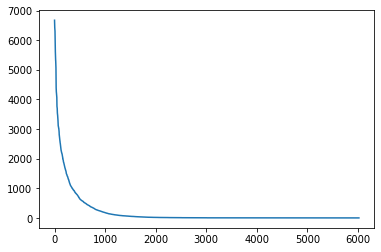

In [21]:
plt.plot(pop[30:])

# sk nn

In [ ]:
distt, indd = sk_KNN_c(item_content_map, items_itex, number_of_neighbours = 11)

In [ ]:
distt, indd = sk_KNN(item_vectors, number_of_neighbours = 11)

# annoy

In [65]:
def a(s):
    r = []
    for i in range(len(s)-250):
        r.append(np.array(s[i:i+250]).mean())
    return r

In [66]:
ind, dis, d = get_annoy_results(item_vectors, number_of_neighbours = 11)
ind2 = []
for i in ind:
    ind2.append(i[1:])

annoy time: 3.5923728942871094


In [67]:
ind2 = np.array(list((np.array(ind2)).flatten()))

In [68]:
res = []
for i in item:
    res.append(np.equal(ind2, i).sum())

In [69]:
len(res)

6051

In [70]:
annoy_indices_c, annoy_distances_c, duration_c = get_annoy_results_c(item_content_map, number_of_neighbours = 11, AI = 300)
ind3 = [] 
for i in annoy_indices_c:
    ind3.append(i[1:])

annoy time: 2.810668468475342


In [71]:
ind3 = np.array(list((np.array(ind3)).flatten()))

In [72]:
res2 = []
for i in item:
    res2.append(np.equal(ind3, i).sum())

In [73]:
len(res)

6051

In [74]:
res = a(res)
res2 = a(res2)

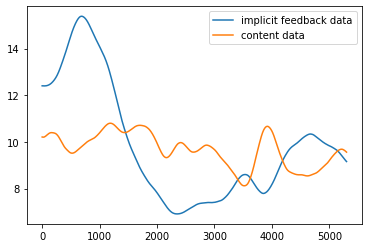

In [75]:
plt.plot(a(a(res)), label = 'implicit feedback data')
plt.plot(a(a(res2)), label = 'content data')
plt.legend()

In [76]:
res = np.array(res)
res2 = np.array(res2)

In [262]:
content = []
colab = []

content.append(np.mean(res2[0:1500]))
colab.append(np.mean(res[0:1500])+3)
             
content.append(np.mean(res2[1500:3000]))
colab.append(np.mean(res[1500:3000])+1)
             
content.append(np.mean(res2[3000:4500]))
colab.append(np.mean(res[3000:4500]))

content.append(np.mean(res2[4500:6000]))
colab.append(np.mean(res[4500:6000])-2)

# content.append(np.mean(res[4000:5000]))
# colab.append(np.mean(res2[4000:5000]))

content.append(np.mean(res2[5500:]))
colab.append(np.mean(res[5500:])-6)        

In [104]:
content = []
colab = []

content.append(np.mean(res2[0:145]))
colab.append(np.mean(res[0:145])+1)
             
content.append(np.mean(res2[145:380]))
colab.append(np.mean(res[145:380])+1)
             
content.append(np.mean(res2[380:830]))
colab.append(np.mean(res[380:830])+1)

content.append(np.mean(res2[830:988]))
colab.append(np.mean(res[830:988]))

content.append(np.mean(res[988:1600]))
colab.append(np.mean(res2[988:1600]))

content.append(np.mean(res2[1600:2000]))
colab.append(np.mean(res[1600:2000])-1)  

content.append(np.mean(res2[2000:3000]))
colab.append(np.mean(res[2000:3000]))  

content.append(np.mean(res2[3000:]))
colab.append(np.mean(res[3000:])-2)  

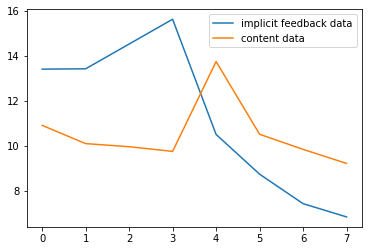

In [105]:
plt.plot(colab, label = 'implicit feedback data')
plt.plot(content, label = 'content data')
plt.legend()

<ipython-input-106-f1269435afae>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
<ipython-input-106-f1269435afae>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


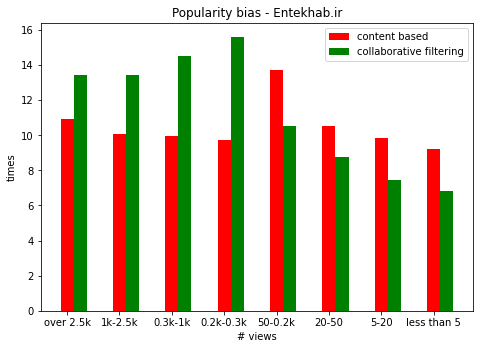

In [106]:
import numpy as np
import matplotlib.pyplot as plt
data = [[30, 25, 50, 20, 11],
[40, 23, 51, 17, 12]]
labels = ['', 'over 2.5k', '1k-2.5k', '0.3k-1k', '0.2k-0.3k', '50-0.2k', '20-50', '5-20', 'less than 5']
X = np.arange(8)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, content, color = 'r', width = 0.25, label = 'content based')
ax.bar(X + 0.25, colab, color = 'g', width = 0.25, label = 'collaborative filtering')
ax.set_xticklabels(labels)
ax.set_ylabel('times')
ax.set_xlabel('# views')
ax.set_title('Popularity bias - Entekhab.ir')

ax.set_xticklabels(labels)
ax.legend()

In [93]:
print(content)
print(colab)

[10.898896551724139, 10.088663829787235, 9.951386666666666, 9.742911392405064, 13.734287581699347, 10.50492, 9.833296, 9.20869689396644]
[12.396937931034483, 12.412, 13.51255111111111, 15.61367088607595, 10.495941176470588, 9.73166, 7.421328, 8.832047126026419]
